In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pydicom as dcm
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score

from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses,optimizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Input data files are available in the read-only "../input/" directory


In [2]:
path = '/kaggle/input/rsna-pneumonia-detection-challenge/'
train = pd.read_csv(path+'/stage_2_train_labels.csv')
train.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Using the patient's lung x-ray images and the target values in the labels dataset, we need to predict whether the patient has pneumonia or not. For that we can access the images using the patient id. The value in the target column indicates whether the patient has pne

In [3]:
#Since we're only using images for prediction, we can safely ignore the other values in the dataset
train = train[['patientId','Target']]

In [4]:
#Counting the different target values. This will be used as dependent variable/prediction target
train['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

## Since there are only two different values in target, this is a binary classification problem. Output layer in the cnn will have one node with sigmoid activation function. The loss function will be binary crossentropy

<AxesSubplot:xlabel='Target'>

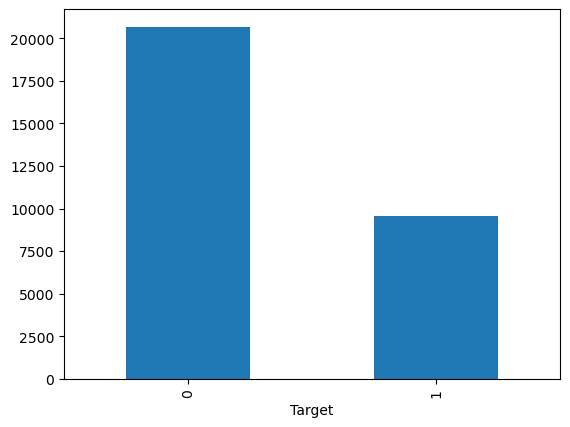

In [5]:
#bar plot
train.groupby('Target').size().plot.bar()

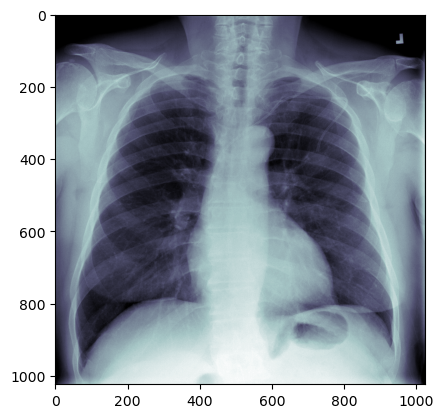

In [6]:
#displaying an image
ds = dcm.dcmread(path+'/stage_2_train_images/ff1bc114-1975-4f8f-9015-54f0d90eb445.dcm')
  
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
plt.show()

In [7]:
#We scale the images to 128x128 pixels and convert them to numpy arrays to be fed
#into the cnn.

ADJUSTED_IMAGE_SIZE = 128

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    imageList = []
    for index, row in rowData.iterrows():
        patientId = row.patientId
        dcm_file = path+'/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
    tmpImages = np.array(imageList)
    return tmpImages

images = populateImage(train)

In [8]:
images.shape

(30227, 128, 128, 3)

In [9]:
#This list of images converted to np arrays of shape 128x128x3 will be used to train the cnn

In [10]:
y = train['Target']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: Target, dtype: int64

In [11]:
y.shape

(30227,)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=42)

In [13]:
#cnn model that takes in 128x128x3 np array and returns a sigmoid output in the range 0-1. loss is binary_crossentropy

def cnn_model(height, width, num_channels = 3, loss='binary_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = "sigmoid"))

  optimizer = Adam(lr=0.001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [14]:
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [15]:
#to stop training before overfitting
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

In [16]:
model_fit = cnn.fit(X_train, 
                    y_train, 
                    epochs = 10, 
                    validation_data = (X_val,y_val),
                    batch_size = 100,
                    callbacks = callbacks)

Epoch 1/10


2023-04-05 13:39:35.766142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


242/242 [==============================] - 31s 89ms/step - loss: 0.9128 - accuracy: 0.6754 - val_loss: 0.6139 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 2/10
242/242 [==============================] - 19s 79ms/step - loss: 0.5614 - accuracy: 0.7096 - val_loss: 0.6132 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 3/10
242/242 [==============================] - 19s 79ms/step - loss: 0.5503 - accuracy: 0.7145 - val_loss: 0.6025 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 4/10
242/242 [==============================] - 19s 79ms/step - loss: 0.5290 - accuracy: 0.7335 - val_loss: 0.5351 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 5/10
242/242 [==============================] - 19s 79ms/step - loss: 0.5116 - accuracy: 0.7500 - val_loss: 0.5591 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 6/10
242/242 [==============================] - 19s 79ms/step - loss: 0.5001 - accuracy: 0.7586 - val_loss: 0.5247 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 7/10
242/242 [==============================] - 19s 80ms/step -

In [17]:
loss, accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

95/95 [==============================] - 1s 8ms/step - loss: 0.4797 - accuracy: 0.7850
Test loss: 0.47972655296325684
Test accuracy: 0.7849817872047424


In [18]:
y_pred = np.round(cnn.predict(X_test)) #Sigmoid output need to be rounded to make it into 0 and 1
pres = precision_score(y_pred, y_test)
acc  = accuracy_score(y_pred, y_test)
print(f"Accuracy Score : {acc} Precision : {pres}")

95/95 [==============================] - 1s 5ms/step
Accuracy Score : 0.7849818061528283 Precision : 0.551255230125523


In [19]:
#Before making predictions with test data, we need to train the NN with the entire raining data for better accuracy
model_fit = cnn.fit(images, 
                    y, 
                    epochs = 10,
                    validation_data = (X_train,y_train),
                    batch_size = 100,
                    callbacks = callbacks)

Epoch 1/10
303/303 [==============================] - 31s 104ms/step - loss: 0.4673 - accuracy: 0.7824 - val_loss: 0.4762 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 2/10
303/303 [==============================] - 28s 94ms/step - loss: 0.4631 - accuracy: 0.7860 - val_loss: 0.4476 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 3/10
303/303 [==============================] - 27s 89ms/step - loss: 0.4542 - accuracy: 0.7908 - val_loss: 0.4843 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 4/10
303/303 [==============================] - 27s 90ms/step - loss: 0.4543 - accuracy: 0.7893 - val_loss: 0.4684 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 5/10
303/303 [==============================] - 27s 89ms/step - loss: 0.4512 - accuracy: 0.7916 - val_loss: 0.4516 - val_accuracy: 0.8026 - lr: 0.0010


In [20]:
#before making predictions with the test dataset, we need to convert the test dataset images into 128x128x3 numpy arrays as we did with the train dataset

folder = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
test_filenames2 = [i[:-4] for i in test_filenames]
test = pd.DataFrame({'patientId':test_filenames2})
test.head()

,patientId
0,12abc170-f1fe-45d3-b574-2f4d030e40cd
1,2abcf934-facd-40fc-a75e-0062441fd206
2,2da69f80-c59d-4e4a-b7e5-1d631ef4186b
3,13e4e6e6-faa2-4bbc-8e1e-610623de994e
4,2afe02a3-06da-42fa-b68f-3e9c921e5fb9


In [21]:
ADJUSTED_IMAGE_SIZE = 128

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateTestImage(rowData):
    imageList = []
    for index, row in rowData.iterrows():
        patientId = row.patientId
        dcm_file = path+'/stage_2_test_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
    tmpImages = np.array(imageList)
    return tmpImages

test_images = populateTestImage(test)
test_images.shape

(3000, 128, 128, 3)

In [22]:
final_preds = np.round(cnn.predict(test_images))
final_preds

94/94 [==============================] - 1s 7ms/step


array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [23]:
test['Target'] = final_preds
test['Target'] = test['Target'].astype(int)
test.head()

,patientId,Target
0,12abc170-f1fe-45d3-b574-2f4d030e40cd,0
1,2abcf934-facd-40fc-a75e-0062441fd206,1
2,2da69f80-c59d-4e4a-b7e5-1d631ef4186b,0
3,13e4e6e6-faa2-4bbc-8e1e-610623de994e,0
4,2afe02a3-06da-42fa-b68f-3e9c921e5fb9,0


In [24]:
test.shape

(3000, 2)

In [25]:
test.to_csv('submission.csv', index=False)